### Drive Mounting

In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [2]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [4]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    epochs = 100
    batch_size = 100
    n_classes = 10

    image_size = (3, 64, 64)

    lr = 0.0002
    beta1 = 0.5

    model_path = "./checkpoint/supervised/model(ResNet50).pt"

    history_path = "./history/supervised/history(ResNet50).csv"

print(Config.device)

cuda


In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [6]:
seed_everything(Config.seed)

### Data Loading

In [7]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [8]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


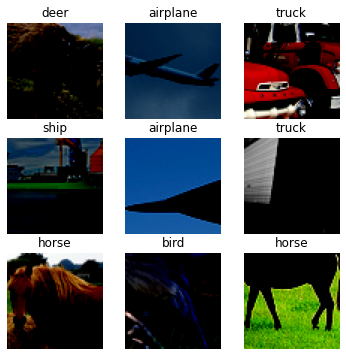

In [10]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [11]:
print("train size: %d" % (len(train_set)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

train size: 4000
validation size: 1000
test size: 8000


In [12]:
train_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride):
        super(ResidualBlock, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        if in_channels != out_channels:
          self.projection = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
          )

        else:
          self.projection = nn.Sequential()

        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        x = self.conv_layers(inputs)
        skip_connection = self.projection(inputs)
        x += skip_connection
        outputs = self.activation(x)
        
        return outputs

In [14]:
class ResNet50(nn.Module):
    def __init__(self, n_classes):
      super(ResNet50, self).__init__()

      self.conv_1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
      )

      self.conv_2 = self.make_block(64, 64, 256, 3, True)
      
      self.conv_3 = self.make_block(256, 128 , 512, 4, True)
      
      self.conv_4 = self.make_block(512, 256, 1024, 6, True)

      self.conv_5 = self.make_block(1024, 512, 2048, 3, True)

      self.avg_pooling = nn.AvgPool2d(kernel_size=4, stride=1)

      self.classifier = nn.Sequential(
          nn.Linear(2048, n_classes),
          nn.Softmax(-1)
      )

      self.initialize_weights()

    def make_block(self, in_channels, mid_channels, out_channels, reps, downsampling):
      outputs = []
      
      if downsampling:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 2))
      
      else:
        outputs.append(ResidualBlock(in_channels, mid_channels, out_channels, 1))

      for i in range(reps-1):
        outputs.append(ResidualBlock(out_channels, mid_channels, out_channels, 1))

      return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)
        elif isinstance(i, nn.BatchNorm2d):
            nn.init.normal_(i.weight, mean=1.0, std=0.02)
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.conv_1(inputs)
      x = self.conv_2(x)
      x = self.conv_3(x)
      x = self.conv_4(x)
      x = self.conv_5(x)
      x = self.avg_pooling(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [15]:
model = ResNet50(n_classes=Config.n_classes).to(Config.device)

summary(model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

### Training Setting

In [16]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=Config.lr, betas=(Config.beta1, 0.999))

In [17]:
def supervised_learning(model, optimizer, epochs, model_path, history_path, train_dl, valid_dl):
    history = {'train_loss':[], 'valid_acc':[]}        
    start_time = time.time()
      
    for epoch in range(epochs): 
        epoch_time = time.time()

        train_losses = 0

        valid_total = 0
        valid_correct = 0

        model.train()
        for inputs, labels in tqdm(train_dl, desc="Training", leave=False):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                optimizer.zero_grad()

                outputs = model(inputs)
                cross_entropy_loss = cross_entropy(outputs, labels)

                loss = cross_entropy_loss
                loss.backward(retain_graph=True)
                optimizer.step()

                train_losses += loss.item()

        train_loss = train_losses / len(train_dl)
        history['train_loss'].append(train_loss)

        model.eval()
        with torch.no_grad():
          for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
              inputs, labels = inputs.to(Config.device), labels.to(Config.device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)

              valid_total += labels.size(0)
              valid_correct += (predicted == labels).sum().item()


        valid_acc = valid_correct / valid_total * 100
        history['valid_acc'].append(valid_acc)

        tqdm.write('[Epoch : %d/%d] train_loss: %.5f, valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (epoch + 1, epochs, train_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

        torch.save(model.state_dict(), model_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return model, history

### Supervised Learning

In [18]:
model, history = supervised_learning(model, optimizer, Config.epochs, Config.model_path, Config.history_path, train_dl, valid_dl)

Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 1/100] train_loss: 2.25843, valid_acc: 21.60, elapsed_time_in_epoch: 00:11


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 2/100] train_loss: 2.21774, valid_acc: 15.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 3/100] train_loss: 2.21974, valid_acc: 21.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 4/100] train_loss: 2.19293, valid_acc: 26.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 5/100] train_loss: 2.18758, valid_acc: 24.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 6/100] train_loss: 2.17864, valid_acc: 23.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 7/100] train_loss: 2.17494, valid_acc: 20.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 8/100] train_loss: 2.16222, valid_acc: 27.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 9/100] train_loss: 2.15468, valid_acc: 25.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 10/100] train_loss: 2.14855, valid_acc: 29.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 11/100] train_loss: 2.13269, valid_acc: 27.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 12/100] train_loss: 2.12543, valid_acc: 29.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 13/100] train_loss: 2.12321, valid_acc: 32.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 14/100] train_loss: 2.14141, valid_acc: 30.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 15/100] train_loss: 2.13675, valid_acc: 23.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 16/100] train_loss: 2.13260, valid_acc: 33.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 17/100] train_loss: 2.11666, valid_acc: 29.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 18/100] train_loss: 2.10057, valid_acc: 33.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 19/100] train_loss: 2.12922, valid_acc: 29.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 20/100] train_loss: 2.11223, valid_acc: 33.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 21/100] train_loss: 2.09304, valid_acc: 33.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 22/100] train_loss: 2.12238, valid_acc: 32.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 23/100] train_loss: 2.09727, valid_acc: 33.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 24/100] train_loss: 2.07793, valid_acc: 32.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 25/100] train_loss: 2.08740, valid_acc: 33.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 26/100] train_loss: 2.07874, valid_acc: 30.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 27/100] train_loss: 2.08008, valid_acc: 36.50, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 28/100] train_loss: 2.06957, valid_acc: 36.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 29/100] train_loss: 2.06849, valid_acc: 32.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 30/100] train_loss: 2.06072, valid_acc: 35.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 31/100] train_loss: 2.08375, valid_acc: 32.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 32/100] train_loss: 2.05972, valid_acc: 37.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 33/100] train_loss: 2.05643, valid_acc: 34.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 34/100] train_loss: 2.06093, valid_acc: 35.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 35/100] train_loss: 2.04703, valid_acc: 32.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 36/100] train_loss: 2.05802, valid_acc: 35.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 37/100] train_loss: 2.03579, valid_acc: 38.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 38/100] train_loss: 2.05283, valid_acc: 38.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 39/100] train_loss: 2.04868, valid_acc: 29.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 40/100] train_loss: 2.04285, valid_acc: 37.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 41/100] train_loss: 2.04484, valid_acc: 36.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 42/100] train_loss: 2.04009, valid_acc: 40.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 43/100] train_loss: 2.02180, valid_acc: 36.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 44/100] train_loss: 2.03062, valid_acc: 37.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 45/100] train_loss: 2.03528, valid_acc: 39.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 46/100] train_loss: 2.02848, valid_acc: 39.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 47/100] train_loss: 2.02818, valid_acc: 37.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 48/100] train_loss: 2.02180, valid_acc: 35.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 49/100] train_loss: 2.02377, valid_acc: 37.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 50/100] train_loss: 2.01552, valid_acc: 41.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 51/100] train_loss: 2.00740, valid_acc: 39.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 52/100] train_loss: 1.99360, valid_acc: 39.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 53/100] train_loss: 2.00175, valid_acc: 42.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 54/100] train_loss: 2.00843, valid_acc: 39.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 55/100] train_loss: 2.00067, valid_acc: 37.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 56/100] train_loss: 2.01034, valid_acc: 43.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 57/100] train_loss: 1.99992, valid_acc: 41.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 58/100] train_loss: 1.97927, valid_acc: 38.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 59/100] train_loss: 1.99674, valid_acc: 40.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 60/100] train_loss: 1.98931, valid_acc: 40.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 61/100] train_loss: 1.99332, valid_acc: 44.50, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 62/100] train_loss: 1.98987, valid_acc: 39.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 63/100] train_loss: 1.98799, valid_acc: 41.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 64/100] train_loss: 1.97567, valid_acc: 41.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 65/100] train_loss: 1.97754, valid_acc: 42.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 66/100] train_loss: 1.98036, valid_acc: 40.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 67/100] train_loss: 1.98504, valid_acc: 41.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 68/100] train_loss: 1.97287, valid_acc: 41.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 69/100] train_loss: 1.97314, valid_acc: 43.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 70/100] train_loss: 1.97252, valid_acc: 42.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 71/100] train_loss: 1.97609, valid_acc: 40.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 72/100] train_loss: 1.97317, valid_acc: 44.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 73/100] train_loss: 1.96157, valid_acc: 41.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 74/100] train_loss: 1.94886, valid_acc: 44.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 75/100] train_loss: 1.95580, valid_acc: 44.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 76/100] train_loss: 1.95838, valid_acc: 43.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 77/100] train_loss: 1.95384, valid_acc: 42.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 78/100] train_loss: 1.95156, valid_acc: 43.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 79/100] train_loss: 1.94573, valid_acc: 46.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 80/100] train_loss: 1.94590, valid_acc: 45.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 81/100] train_loss: 1.93640, valid_acc: 44.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 82/100] train_loss: 1.91974, valid_acc: 45.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 83/100] train_loss: 1.90939, valid_acc: 48.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 84/100] train_loss: 1.93603, valid_acc: 43.00, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 85/100] train_loss: 1.93638, valid_acc: 44.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 86/100] train_loss: 1.92172, valid_acc: 45.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 87/100] train_loss: 1.92246, valid_acc: 44.30, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 88/100] train_loss: 1.93488, valid_acc: 46.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 89/100] train_loss: 1.91145, valid_acc: 43.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 90/100] train_loss: 1.92112, valid_acc: 45.90, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 91/100] train_loss: 1.92026, valid_acc: 48.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 92/100] train_loss: 1.92275, valid_acc: 46.60, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 93/100] train_loss: 1.91432, valid_acc: 47.70, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 94/100] train_loss: 1.90966, valid_acc: 44.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 95/100] train_loss: 1.91917, valid_acc: 45.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 96/100] train_loss: 1.90183, valid_acc: 46.20, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 97/100] train_loss: 1.90287, valid_acc: 47.40, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 98/100] train_loss: 1.89559, valid_acc: 43.80, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 99/100] train_loss: 1.89987, valid_acc: 48.10, elapsed_time_in_epoch: 00:10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch : 100/100] train_loss: 1.89937, valid_acc: 49.10, elapsed_time_in_epoch: 00:10
Finished training
Total elapsed time: 17:47


### Testing

In [19]:
model.load_state_dict(torch.load(Config.model_path))

test_total = 0
test_correct = 0

model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("supervised_model test_acc: %.5f" %(test_acc))

supervised_model test_acc: 51.17500
